In [5]:
import meep as mp
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
from numpy import cos, sin
import json
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt

# create geometric and write it to a file

generate random numbers

In [6]:
np.random.seed(15)

num_crystal = 190

a = 5. # shape

size_cell_l = [2, 2, 2]
size_solid_l = [1, 1, 1]
size_crystal_base = [0.1, 0.1, 0.1]
size_crystal_l = np.random.weibull(a, (num_crystal, 3))
for i in range(3):
    size_crystal_l[:, i] *= size_crystal_base[i]

size_cell = mp.Vector3(*size_cell_l)
size_solid = mp.Vector3(*size_solid_l)

size_crystal = []
for i in range(num_crystal):
    size_crystal.append(mp.Vector3(*size_crystal_l[i, :]))

solid_region = mp.Block(size_solid, 
                    center = mp.Vector3(0, 0, 0),
                    material=mp.Medium(epsilon=1))

mean= (0, 0, 0)
cov = [[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]]
loc = np.random.multivariate_normal(mean, cov, (num_crystal))
loc = np.random.uniform(-size_solid_l[0]/2, size_solid_l[0]/2, (num_crystal, 3))
theta_x = np.random.uniform(0, 2*np.pi, num_crystal)
theta_y = np.random.uniform(0, 2*np.pi, num_crystal)
theta_z = np.random.uniform(0, 2*np.pi, num_crystal)

Voronoi tesse

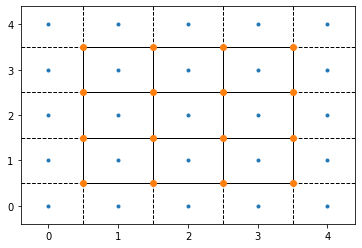

In [23]:
def plot_2d_v(points):
    num_div = 5
    # points = np.zeros((num_div**2, 2)

    index = 0
    for i in range(num_div):
        for j in range(num_div):
            points[index, :] = [i, j]
            index += 1


    from scipy.spatial import Voronoi, voronoi_plot_2d
    vor = Voronoi(points)
    import matplotlib.pyplot as plt
    voronoi_plot_2d(vor)
    plt.show()
    # print(vor.regions)

In [8]:
R = np.empty((num_crystal, 3, 3))

Rx_matrix = np.empty((num_crystal, 3, 3))
Ry_matrix = np.empty((num_crystal, 3, 3))
Rz_matrix = np.empty((num_crystal, 3, 3))

for i in range(num_crystal):
    Rx_matrix[i, :, :] = np.array([[1, 0, 0],
                   [0, cos(theta_x[i]), -sin(theta_x[i])], 
                  [0, sin(theta_x[i]), cos(theta_x[i])]])
    
    Ry_matrix[i, :, :] = np.array([[cos(theta_y[i]), 0, sin(theta_y[i])], 
                  [0, 1, 0],
                  [-sin(theta_y[i]), 0, cos(theta_y[i])]])
    
    Rz_matrix[i, :, :] = np.array([[cos(theta_z[i]), -sin(theta_z[i]), 0],
                 [sin(theta_z[i]), cos(theta_z[i]), 0],
                 [0, 0, 1]])

    R[i, :, :] = np.matmul(np.matmul(Ry_matrix[i, :, :], Rx_matrix[i, :, :]), Rz_matrix[i, :, :])


og_x = np.array([[1, 0, 0] for i in range(num_crystal)])
og_y = np.array([[0, 1, 0] for i in range(num_crystal)])
og_z = np.array([[0, 0, 1] for i in range(num_crystal)])

Rx_vector = np.empty((num_crystal, 3))
Ry_vector = np.empty((num_crystal, 3))
Rz_vector = np.empty((num_crystal, 3))

for i in range(num_crystal):
    Rx_vector[i, :] = np.matmul(R[i, :, :], og_x[i, :])
    Ry_vector[i, :] = np.matmul(R[i, :, :], og_y[i, :])
    Rz_vector[i, :] = np.matmul(R[i, :, :], og_z[i, :])

geometry = [solid_region,]

for i in range(num_crystal):
    if (np.abs(loc[i, 0]) < size_solid[0] - size_crystal_base[0]/2 and 
    np.abs(loc[i, 1]) < size_solid[1] - size_crystal_base[1]/2 and 
    np.abs(loc[i, 2]) < size_solid[2] - size_crystal_base[2]/2):
        geometry.append(mp.Block(
            size_crystal[i],
            center = mp.Vector3(loc[i, 0], loc[i, 1], loc[i, 2]),
            e1 = Rx_vector[i, :],
            e2 = Ry_vector[i, :],
            e3 = Rz_vector[i, :],
            material=mp.Medium(epsilon=10.5)))



In [9]:
export_geo = True

if export_geo:
    file_name = 'geometry.peter'
    to_write = [num_crystal, size_solid_l, size_crystal_l, loc, theta_x, theta_y, theta_z]
    for i in range(len(to_write)):
        if type(to_write[i]) is not int and type(to_write[i]) is not list:
            to_write[i] = to_write[i].tolist()
    with open(file_name, 'w') as f:
        json.dump(to_write, f)

#\\ad.monash.edu\home\User045\dche145\Documents\Abaqus\geometry_shapes
#\\Client\D$\source\working_with_meep

helper functions

In [ ]:
def closest_node(node, nodes):
    # nodes = np.asarray(nodes)
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argmin(dist_2)

    
def my_mat(coord):
    if coord[0] <  0.25 and coord[0] > -0.25 :
        return mp.Medium(epsilon=10.5)
    else:
        return mp.Medium(epsilon=1)

def my_eps(coord):
    acoord = np.abs(coord)
    if (acoord[0] < 0.5 and acoord[1] < 0.5 and acoord[2] < 0.5 ):
        return parts_eps[closest_node([coord[0],coord[1],coord[2]], points)]
    else:
        return 1.0

def my_part_ass(coord):
    if (acoord[0] < 0.5 and acoord[1] < 0.5 and acoord[2] < 0.5 ):
        return parts_ass[closest_node([coord[0],coord[1],coord[2]], points)]
    else:
        return 1.0

def index2coord(index, size_arr, size_geo):
    index = (index/size_arr - 0.5)*size_geo
    return index

In [77]:
points

array([[ 0.3488177 , -0.32110408, -0.44563679],
       [-0.13846155, -0.22459907,  0.03000022],
       [-0.19408108, -0.19552564, -0.38825872],
       [-0.25010099,  0.4176299 , -0.23585315],
       [ 0.21777369,  0.36571503,  0.30707948],
       [-0.28944942, -0.33275697, -0.45329361],
       [-0.46057769, -0.29976919,  0.4985434 ],
       [-0.12721302,  0.26051027, -0.02652556],
       [ 0.00971531,  0.44503842, -0.39055335],
       [-0.03490684, -0.35844474,  0.03834876],
       [-0.20100134,  0.03774522,  0.16562754],
       [-0.1356712 ,  0.12301862,  0.14272489],
       [-0.08001818, -0.09675757, -0.10957967],
       [-0.09381048, -0.42033389, -0.4431688 ],
       [-0.42166909,  0.19567781, -0.47084104],
       [-0.00050758, -0.36736568, -0.46924437],
       [ 0.13948943, -0.05400185,  0.47460664],
       [-0.17023407, -0.30457518,  0.18404621],
       [-0.14890114,  0.27103611,  0.2917995 ],
       [-0.05612541, -0.2311717 , -0.47609558],
       [-0.12866743, -0.40226912,  0.227

In [79]:
num_div = 5
num_seed = num_div**3
points = np.zeros((num_div**3, 3))

p_range = np.array([1.0, 1.0, 1.0])
p_div = p_range/num_div
num_parts = 2
eps_val = [1, 10]

# vor = Voronoi(points)

# assigning points and seeds
random_ass = False
if random_ass:
    np.random.seed(15)
    points = np.random.rand(num_seed, 3) - 0.5
    parts_ass = np.random.randint(0, num_parts, (num_seed))
else:
    index = 0
    for i in range(num_div):
        for j in range(num_div):
            for k in range(num_div):
                points[index, :] = [i*p_div[0] - p_range[0]/2, j*p_div[1] - p_range[1]/2, k*p_div[2] - p_range[2]/2]
                index += 1
    # this will produce checker pattern
    parts_ass = np.array([1 if i%2 else 0 for i in range(num_seed)])

parts_eps = [eps_val[parts_ass[i]] for i in range(num_seed)]


#output geometric files
size_out_geo = [100, 100, 100]
out_geo = np.zeros((size_out_geo))
for i in range(size_out_geo[0]):
    for j in range(size_out_geo[1]):
        for k in range(size_out_geo[2]):
            coord = index2coord(np.array((i,j,k),dtype=float), size_out_geo, size_cell_l)
            out_geo[i,j,k] = parts_ass[closest_node(coord, points)]
with open('../abaqus_working_space/abaqus_out/voronoi_geo.peter', 'wb') as f:
    out_geo.tofile(f)


#construct the geometry
pml_layers = [mp.PML(0.3)]

source_pad = 0.25
source = [mp.Source(mp.ContinuousSource(wavelength=2*(11**0.5), width=20),
                   component=mp.Ez,
                   center=mp.Vector3(0.75, 0, 0),
                   size=mp.Vector3(0, 0.1, 0.1))]
sim = mp.Simulation(resolution=100,
                    cell_size=size_cell,
                    boundary_layers=pml_layers,
                    sources = source,
                    epsilon_func = my_eps)


Create the visualization for visual inspection

In [78]:
sim.init_sim()
eps_data = sim.get_epsilon()

show_3d_geo = True
if show_3d_geo:
    from mayavi import mlab
    s = mlab.contour3d(eps_data, colormap="YlGnBu")
    mlab.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.00049305 s
Working in 3D dimensions.
Computational cell is 2 x 2 x 2 with resolution 100
subpixel-averaging is 67.2841% done, 1.94502 s remaining
subpixel-averaging is 66.3137% done, 2.03259 s remaining
subpixel-averaging is 64.0493% done, 2.24755 s remaining
subpixel-averaging is 64.858% done, 2.17093 s remaining
subpixel-averaging is 63.7258% done, 2.2817 s remaining
subpixel-averaging is 63.7258% done, 2.28241 s remaining
subpixel-averaging is 14.559% done, 23.6618 s remaining
subpixel-averaging is 20.1443% done, 15.8662 s remaining
subpixel-averaging is 25.7668% done, 11.5651 s remaining
subpixel-averaging is 31.4638% done, 8.72513 s remaining
subpixel-averaging is 37.1236% done, 6.82903 s remaining
subpixel-averaging is 42.7834% done, 5.37021 s remaining
subpixel-averaging is 48.4432% done, 4.26922 s remaining
subpixel-averaging is 54.1029% done, 3.40373 s remaining
subpixel-averaging is 59.5393% done, 2.73369

cheeky run of the geometry

In [7]:
sim.run(mp.at_beginning(mp.output_epsilon), 
       mp.to_appended("ez_small", mp.at_every(0.6, mp.output_efield_z)),
       until=20)

creating output file "./eps-000000.00.h5"...
creating output file "./ez_small.h5"...
Meep progress: 0.43/20.0 = 2.1% done in 4.0s, 182.1s to go
on time step 46 (time=0.46), 0.0869736 s/step
Meep progress: 1.2/20.0 = 6.0% done in 8.1s, 127.1s to go
on time step 121 (time=1.21), 0.0536495 s/step
Meep progress: 1.99/20.0 = 9.9% done in 12.1s, 109.9s to go
on time step 200 (time=2), 0.0509718 s/step
Meep progress: 2.82/20.0 = 14.1% done in 16.1s, 98.4s to go
on time step 283 (time=2.83), 0.0483065 s/step
Meep progress: 3.6/20.0 = 18.0% done in 20.4s, 93.1s to go
on time step 360 (time=3.6), 0.0549899 s/step
Meep progress: 4.3500000000000005/20.0 = 21.8% done in 24.5s, 88.1s to go
on time step 435 (time=4.35), 0.0539277 s/step
Meep progress: 5.1000000000000005/20.0 = 25.5% done in 28.5s, 83.3s to go
on time step 510 (time=5.1), 0.0537785 s/step
Meep progress: 5.86/20.0 = 29.3% done in 32.5s, 78.5s to go
on time step 586 (time=5.86), 0.0526459 s/step
Meep progress: 6.59/20.0 = 32.9% done in 

visulization of the output field

In [38]:
# ez_data = sim.get_array(center=mp.Vector3(), size=size_cell, component=mp.Ez)
# print(ez_data.shape)
get_gif_out = False

if get_gif_out:
    !h5ls ez.h5
    !mkdir temp
    !mv eps-000000.00.h5 temp/eps-000000.00.h5
    !mv ez.h5 temp/ez.h5
    import os
    os.chdir('temp')
    !h5topng -z 20 -t 0:332 -R -Zc dkbluered -a yarg -A eps-000000.00.h5 ez.h5
    !convert ez.t*.png ez.gif
    os.chdir('..')

(100, 100, 100)
ez                       Dataset {100, 100, 100, 333/Inf}
h5topng error: invalid colormap file
